<a href="https://colab.research.google.com/github/bubuloMallone/NeuralNetworksEX/blob/main/mlp_internals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
!wget https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksEX/refs/heads/main/datasets/names.txt

words = open('names.txt', 'r').read().splitlines()

words[:10]

--2025-07-09 13:53:53--  https://raw.githubusercontent.com/bubuloMallone/NeuralNetworksEX/refs/heads/main/datasets/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.05s   

2025-07-09 13:53:53 (4.29 MB/s) - ‘names.txt’ saved [228145/228145]



['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(list(set(''.join(words))))
alphabet_size = len(chars) + 1
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(alphabet_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset

# define the context length: how many char we consider to predict the next one
block_size = 3

def build_dataset(words):
  X, Y = [], []

  for word in words:

    context = [0] * block_size
    for ch in word + '.':
      idx = stoi[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(itos[i] for i in context), '--->', itos[idx])
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print('Data:', X.shape, X.dtype)
  print('Labels:', Y.shape, Y.dtype)
  num_samples = X.shape[0]

  return X, Y, num_samples


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr, num_samples_tr = build_dataset(words[:n1])
Xval, Yval, num_samples_val = build_dataset(words[n1:n2])
Xte, Yte, num_samples_te = build_dataset(words[n2:])

Data: torch.Size([182580, 3]) torch.int64
Labels: torch.Size([182580]) torch.int64
Data: torch.Size([22767, 3]) torch.int64
Labels: torch.Size([22767]) torch.int64
Data: torch.Size([22799, 3]) torch.int64
Labels: torch.Size([22799]) torch.int64


Initialization and its impacts on training performances

Note 1: Avoid high initial random logits.

Initialize W2,b2 properly!

In [16]:
# We want that at initialization the network assigns equal probabilities to all characters
# the expected inital loss should be something similar to
print(-torch.tensor(1/float(alphabet_size)).log())

tensor(3.2958)


In [28]:
# at initialization instead the network is creating probs that are all messed up, i.e. some are very confident andd some are very confidently wrong.
# example: let us suppose the idx=2 is the correct label to predict
idx = 2
print('correct label: ', idx)

logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.tensor([-3.0, 7.0, 1.0, 2.0])
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

logits = torch.randn(4) * 20
probs = F.softmax(logits, dim=0)
loss = -probs[idx].log()
print('logits: ', logits)
print('probs: ', probs)
print('loss: ', loss)

# therefore if the initial logits are relatively big random numbers then the loss will be very high
# we want the inital logits to be close to zero even though still random

correct label:  2
logits:  tensor([0., 0., 0., 0.])
probs:  tensor([0.2500, 0.2500, 0.2500, 0.2500])
loss:  tensor(1.3863)
logits:  tensor([0., 0., 5., 0.])
probs:  tensor([0.0066, 0.0066, 0.9802, 0.0066])
loss:  tensor(0.0200)
logits:  tensor([-3.,  7.,  1.,  2.])
probs:  tensor([4.4983e-05, 9.9082e-01, 2.4560e-03, 6.6761e-03])
loss:  tensor(6.0092)
logits:  tensor([-29.1832, -34.9111, -14.7261,  -3.0207])
probs:  tensor([4.3429e-12, 1.4131e-14, 8.2490e-06, 9.9999e-01])
loss:  tensor(11.7054)


In [40]:
# MLP architecture

g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
hidden_dim = 200

# embedding
C = torch.randn((alphabet_size, emb_dim))
# first fully connected layer
W1 = torch.randn((block_size * emb_dim, hidden_dim), generator=g) * 0.2  # to avoid dead neurons
b1 = torch.randn(hidden_dim, generator=g) * 0.01  # to avoid dead neurons
# second fully connected layer
W2 = torch.randn((hidden_dim, alphabet_size), generator=g) * 0.01  # to keep low initial logits
# note better not to set W2 exactly to zero!
b2 = torch.randn(alphabet_size, generator=g) * 0   # to keep low initial logits

parameters = [C, W1, b1, W2, b2]

# require gradients
for p in parameters:
  p.requires_grad = True

tot_parameters = sum(p.nelement() for p in parameters)
print(f'Total number of parameters: {tot_parameters}')

Total number of parameters: 11897


In [41]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):

  # minibatch construct
  idxs = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)  # (num_samples,) --> (batch_size,)
  Xb, Yb = Xtr[idxs], Ytr[idxs]  # (batch_size, block_size) and (batch_size,)

  # forward pass
  emb = C[Xb]   # (batch_size, block_size, emb_dim)
  emb_cat = emb.view(emb.shape[0], -1)  # (batch_size, block_size * emb_dim)
  h_preact = emb_cat @ W1 + b1   # (batch_size, hidden_dim)
  h = torch.tanh(h_preact)   # (batch_size, hidden_dim)
  logits = h @ W2 + b2    # (batch_size, alphabet_size)
  loss = F.cross_entropy(logits, Yb)
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  learning_rate = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -learning_rate * p.grad

  # track stats
  if i % 10000 == 0 : # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  losses.append(loss.log10().item())

  break

      0/ 200000: 3.3228


Note 2: Non-linerarity of the hidden layr might kill gradients!

The initialization of the weight and biases could be such that the hidden layer has dead neurons, i.e. neurons that never activate. This happens when the pre-activation of the neuron yield to a flat tail of the activation function, with vanishing gradient, no matter what the input sample is. This means the dead neuron will never learn the weights and biases on the data.

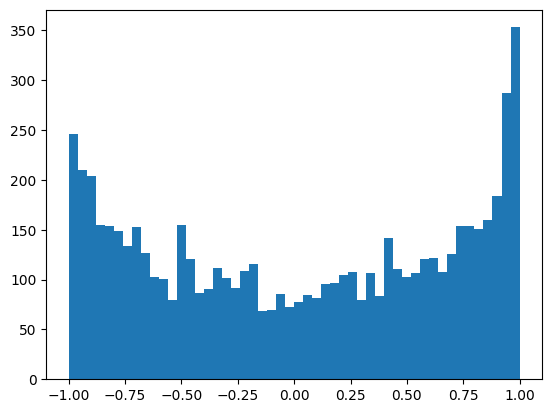

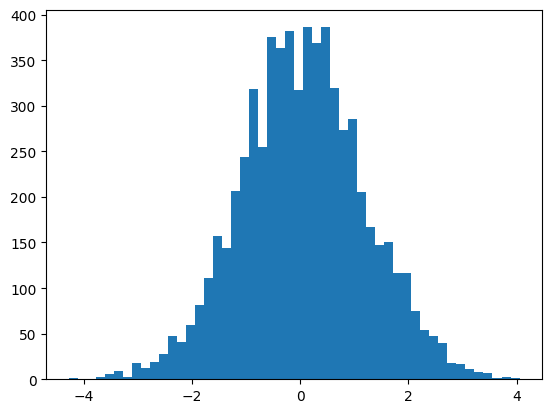

In [42]:
plt.hist(h.view(-1).tolist(), bins=50)
plt.show()

plt.hist(h_preact.view(-1).tolist(), bins=50)
plt.show()

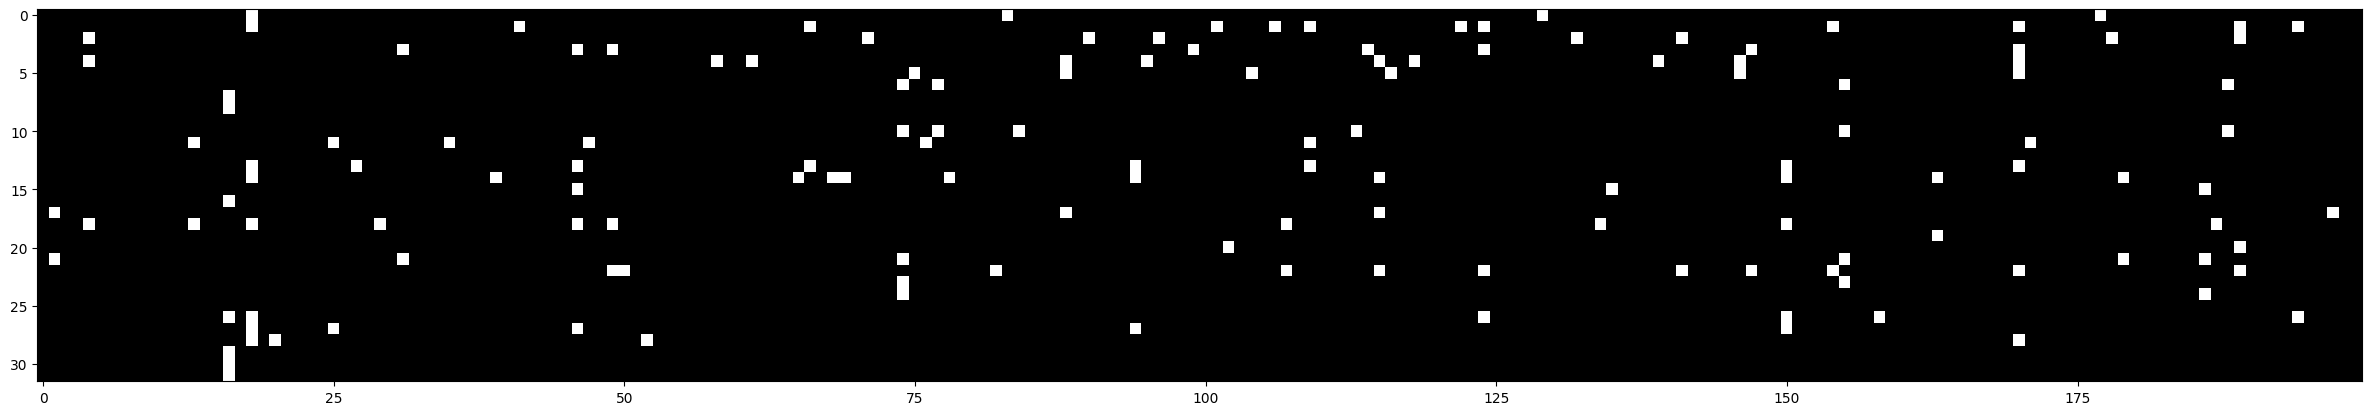

In [46]:
plt.figure(figsize=(30,15))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')
plt.show()

# Again we want the initialized preactivation to stay close to zero
# so that the non-linearity is not saturated and the gradients are not vanishing.

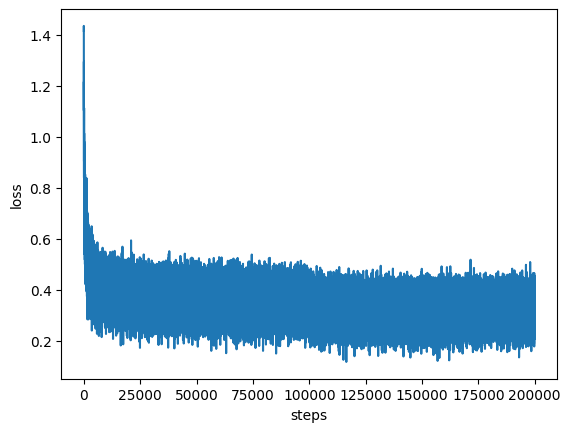

In [11]:
plt.plot(losses)
plt.xlabel('steps')
plt.ylabel('loss')
plt.show()

In [12]:
# evaluate the model on a set
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xte, Yte),
  }[split]

  # forward pass
  emb = C[x]   # (set_size, block_size, emb_dim)
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)   # (set_size, hidden_dim)
  logits = h @ W2 + b2    # (set_size, alphabet_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.1204123497009277
val 2.1620218753814697


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size   # initialize the sampling context with "..."
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs, num_samples=1, replacement = True, generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayannieel.
nihriah.
remyra.
endraega.
zeredgeliah.
milopa.
eden.
estanar.
katelmonter.
noshub.
rishiriel.
kin.
reelynn.
noella.
uzabelder.
yarleyeh.
yuma.
miston.
mahil.
